# Runge-Kutta Methods
Runge-Kutta (RK) methods are single step time marching schemes that use a quadrature rule to compute cheap intermediate solutions and from a combination of these, they compute a final, high order solution to the step.
Sounds familiar?
Indeed, there are a lot of similarities between RK schemes and spectral deferred corrections (SDC)!

So what are the differences?
The most pronounced difference is that RK methods are direct instead of iterative, but SDC is a direct method as well, if you always perform the same number of iterations.
Actually, in the special case of a single iteration and without preconditioning, SDC is an RK method!

Significant differences arise in practice from how people deal with the fact that the quadrature matrix is dense, making a direct solution computationally expensive.
In SDC, we take a preconditioner such that we never have to solve the full dense system but iterate with cheaper problems that get us closer to the solution of the dense system.
In RK schemes, however, people usually use different quadrature rules that rely on more intermediate solutions (stages in the RK jargon) to reach the same order but which are lower diagonal like the preconditioners in SDC.
Now we can solve the systems easily again with forward substitution.
In fact, some of the most popular RK schemes are explicit, meaning the quadrature rules are striclty lower triangular and we don't have to solve anything at all!

## Implementation as a sweeper in pySDC
The fact that there are so many similarities between the RK schemes that people use in practice and SDC means we can easily misuse the sweeper module and change some parameters to get RK behaviour within the same framework we know and love.

The sweeper does the same thing as other sweepers: It sweeps through the collocation nodes and updates the solutions at the nodes, but it completely forgoes the preconditioner.

A general lower triangular RK scheme is usually written like this:
$$u_{n+1} = u_n + \Delta t \sum_{i=1}^s b_i k_i,$$
with the stages
$$k_i = f\left(u_n+\Delta t\sum_{j=1}^i a_{ij}k_j, t_n+c_i\Delta t\right),$$
and the nodes $c_i$.
$f$, $u$, and $\Delta t$ follow the usual definitions of right hand side, solution and step size.
$s$ is the number of stages of the scheme.
Defining the method are the Runge-Kutta matrix $a_{ij}$ and the weights $b_i$.
These are written in a Butcher tableau.

We are familiar with nodes.
We have them in SDC the same way as here.
What is the connection between $a_{ij}$ and $b_i$ and the quadrature matrix $q_{ij}$?
In SDC, we had a collocation matrix one larger in each direction than the number of nodes to store the initial conditions.
Here, we generate a quadrature matrix two larger in both directions to store the initial conditions as well as the final solution.
That means the last row of the quadrature matrix will carry the weights: $q_{s+1,j+1}=b_j$ and we just put the rule to compute intermediate stages in the rest of the quadrature matrix: $q_{ij}=a_{ij}$ for $1 < i,j\leq s$.

Don't worry about the shifted indices.
There is no interesting maths here, it's just needed to conform to the decision to add a row and column for the initial conditinons in the regular sweepers.
We could now actually set the preconditioner to the same as the quadrature matrix and use existing sweepers, but to avoid overhead by adding a lot of stuff and subtracting the same stuff again, we build a new sweeper with no preconditioner.

## Practical tests
We confirm that this works by using a few popular RK schemes.
Namely, we try implicit Euler (RK1), implicit midpoint method, Crank-Nicholson, explicit RK4 and Cash-Karp on the van der Pol problem:

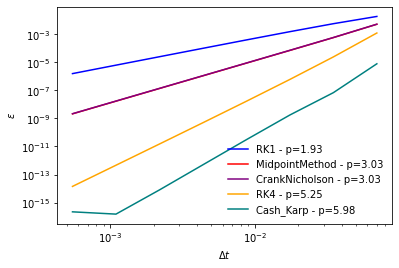

In [1]:
from pySDC.projects.Resilience.test_Runge_Kutta_sweeper import test_vdp, plot_all_stability, test_embedded_method
test_vdp()

In the above plot, you can see the local error versus the step size and p in the legend refers to the numerically computed order of the scheme.
Since we have a method of order 1, 2, 4 and 5, we are happy to see the local error is of order 2, 3, 5 and 6, just as we expect.

Let's look at stability next.

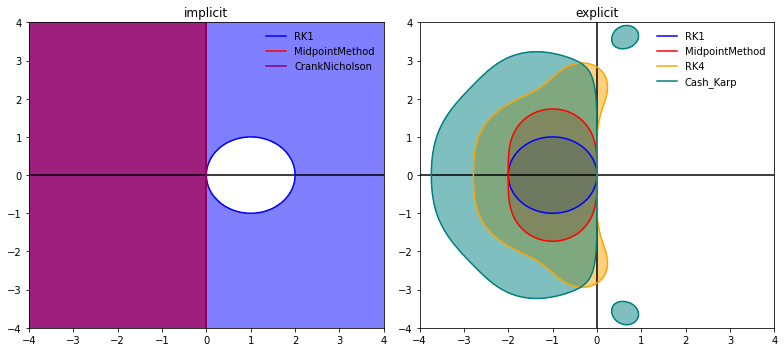

In [2]:
plot_all_stability()

in the above plot you can see the regions of stability for implicit and explicit methods.
Please be aware that implicit Euler is also stable in the left half plane which is covered by the regions of stability of the second order methods.

## Embedded methods
Embedded methods make use of two different Runge-Kutta rules of different order and usse them to estimate the local error, which, in turn, can be used to compute an optimal step size.
Let's try Cash-Karp's method the van der Pol problem:

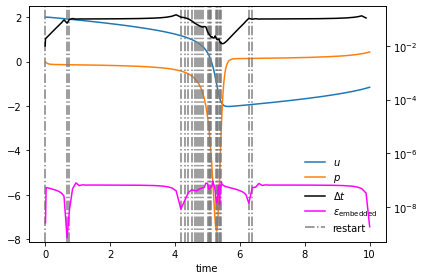

In [3]:
test_embedded_method()

We can see that the step size in black is refined by about an order of magnitude to properly resolve the fast time-scale region at around $t=5$.
We have to perfrom quite a few restarts, but we indeed achieve good temporal resolution throughout.